In [3]:
import os
import random
#%load_ext autotime

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [2, 2]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import LabeledDataset
from data_helper_triangle_down import TriangleLabeledDataset,image_names
from helper import collate_fn, draw_box

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

%load_ext autoreload
%autoreload 2

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

labeled_scene_index = np.arange(106, 134)
image_names

['CAM_FRONT.jpeg',
 'CAM_FRONT_LEFT.jpeg',
 'CAM_BACK_LEFT.jpeg',
 'CAM_BACK.jpeg',
 'CAM_BACK_RIGHT.jpeg',
 'CAM_FRONT_RIGHT.jpeg']

In [4]:
normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                     std=[0.31936955, 0.3117349 , 0.2953726 ])

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           normalize
                                           ])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True,
                                 )

trainloader = torch.utils.data.DataLoader(labeled_trainset , batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [5]:
sample, target, road_image, extra = iter(trainloader).next()

In [6]:
torch.stack(sample).transpose(0,1)


tensor([[[[[ 1.1288e+00,  1.1288e+00,  1.1288e+00,  ...,  1.1288e+00,
             1.1288e+00,  1.1288e+00],
           [ 1.1288e+00,  1.1288e+00,  1.1288e+00,  ...,  1.1288e+00,
             1.1288e+00,  1.1288e+00],
           [ 1.1288e+00,  1.1288e+00,  1.1288e+00,  ...,  1.1288e+00,
             1.1288e+00,  1.1288e+00],
           ...,
           [-1.1138e-01, -4.9987e-02,  6.0524e-02,  ...,  1.0551e+00,
             1.1288e+00,  1.1288e+00],
           [ 5.7625e-01,  6.3764e-01,  7.2360e-01,  ...,  7.9727e-01,
             7.1132e-01,  7.1132e-01],
           [ 1.0674e+00,  1.1042e+00,  1.1288e+00,  ...,  3.3066e-01,
             1.5876e-01,  1.5876e-01]],

          [[ 1.0409e+00,  1.0409e+00,  1.0409e+00,  ...,  1.0409e+00,
             1.0409e+00,  1.0409e+00],
           [ 1.0409e+00,  1.0409e+00,  1.0409e+00,  ...,  1.0409e+00,
             1.0409e+00,  1.0409e+00],
           [ 1.0409e+00,  1.0409e+00,  1.0409e+00,  ...,  1.0409e+00,
             1.0409e+00,  1.0409e+00],
 

In [7]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           normalize
                                           ])
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = TriangleLabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True,
                                camera = 'CAM_FRONT.jpeg'
                                 )

In [9]:
sample, target, road_image, extra = iter(trainloader).next()
plt.imshow(sample[0].numpy().transpose(1, 2, 0))
plt.axis('off');
fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

ValueError: axes don't match array

In [15]:
sample, target, road_image, extra, road_image_mod = iter(trainloader).next()

time: 607 ms


In [16]:
torch.stack(sample, 0).shape

torch.Size([2, 3, 256, 306])

time: 26.9 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


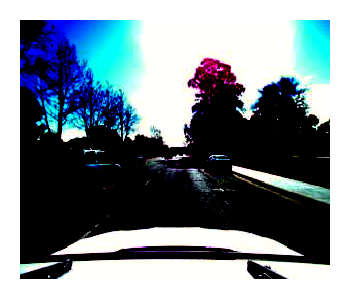

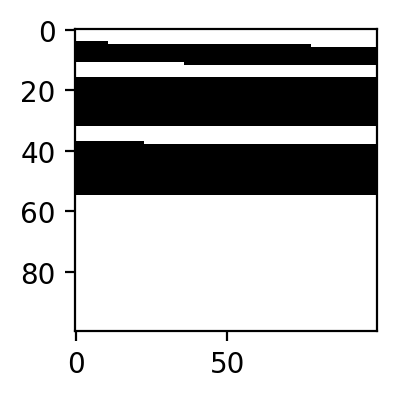

time: 408 ms


In [17]:

plt.imshow(sample[0].numpy().transpose(1, 2, 0))
plt.axis('off');
fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

In [18]:
crop_size = {cam:np.load(cam.replace(".jpeg",".npy")).sum() for cam in image_names}
crop_size

{'CAM_FRONT.jpeg': 111760,
 'CAM_FRONT_LEFT.jpeg': 131238,
 'CAM_BACK_LEFT.jpeg': 125103,
 'CAM_BACK.jpeg': 111759,
 'CAM_BACK_RIGHT.jpeg': 131237,
 'CAM_FRONT_RIGHT.jpeg': 125103}

time: 30 ms


In [19]:
crop_size = {cam:np.load(cam.replace(".jpeg",".npy")).sum() for cam in image_names}
crop_size
training_tools = {cam: (nn.Linear(512, crop_size[cam]), TriangleLabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True,
                                camera = cam)) for cam in image_names}
    
model = torchvision.models.resnet18()


{'CAM_FRONT.jpeg': 111760,
 'CAM_FRONT_LEFT.jpeg': 131238,
 'CAM_BACK_LEFT.jpeg': 125103,
 'CAM_BACK.jpeg': 111759,
 'CAM_BACK_RIGHT.jpeg': 131237,
 'CAM_FRONT_RIGHT.jpeg': 125103}

time: 4.84 s


In [20]:
for cam in image_names:
    print(cam[:-5])

CAM_FRONT
CAM_FRONT_LEFT
CAM_BACK_LEFT
CAM_BACK
CAM_BACK_RIGHT
CAM_FRONT_RIGHT
time: 63.6 ms


In [21]:
image_names

['CAM_FRONT.jpeg',
 'CAM_FRONT_LEFT.jpeg',
 'CAM_BACK_LEFT.jpeg',
 'CAM_BACK.jpeg',
 'CAM_BACK_RIGHT.jpeg',
 'CAM_FRONT_RIGHT.jpeg']

time: 16.3 ms


In [25]:
cam_mask=np.load("CAM_FRONT_100.npy")
road=road_image[0]
fr = road.reshape(-1).numpy()
torch.Tensor(fr[cam_mask])
road[cam_mask.reshape(100,100)].shape

tensor([1., 1., 1.,  ..., 0., 0., 0.])

torch.Size([1720])

time: 65 ms


In [26]:
cam_mask.shape

(10000,)

time: 22.6 ms


In [27]:
road[cam_mask.reshape(800,800)]

ValueError: cannot reshape array of size 10000 into shape (800,800)

time: 53 ms


In [ ]:
#### CP EDITS BELOW###

In [15]:
training_tools = {cam: (nn.Linear(512, crop_size[cam]), 
                           
                           TriangleLabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True,
                                camera = cam)) for cam in image_names}

time: 2.22 s


In [16]:
training_tools["CAM_FRONT.jpeg"][0]

Linear(in_features=512, out_features=111760, bias=True)

time: 12.1 ms


In [17]:
model = torchvision.models.resnet18()

time: 141 ms


In [18]:
model.fc.out_features

1000

time: 12.1 ms


In [19]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

time: 13 ms


In [20]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

time: 13.8 ms


In [21]:
def gen_train_val_index(labeled_scene_index):
    breakpt = len(labeled_scene_index)//3
    labeled_scene_index_shuf = labeled_scene_index
    random.shuffle(labeled_scene_index_shuf)

    train_labeled_scene_index = labeled_scene_index_shuf[:-breakpt]
    val_labeled_scene_index = labeled_scene_index_shuf[-breakpt: ]
    return train_labeled_scene_index, val_labeled_scene_index

time: 14.5 ms


In [22]:
# def gen_masked_road_image(road_image, road_image_mod):
#     alist = []
#     for i in range(len(road_image)):
#         mri = road_image[i][road_image_mod[i].reshape(800,800)]
#         alist.append(mri)
#     return alist

time: 12 ms


In [23]:
train_labeled_scene_index, val_labeled_scene_index = gen_train_val_index(labeled_scene_index)

time: 13 ms


In [24]:
training_tools = {cam: (nn.Linear(512, crop_size[cam]), 
                           #training set
                           TriangleLabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=transform,
                                  extra_info=True,
                                camera = cam),
                           #validation set
                            TriangleLabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=transform,
                                  extra_info=True,
                                camera = cam),
                       
                       
                       ) for cam in image_names}

time: 2.81 s


In [25]:
cam_mask_dict = {cam:np.load(cam.replace(".jpeg",".npy")) for cam in image_names}

time: 14.5 ms


In [26]:
a_mas = cam_mask_dict["CAM_FRONT.jpeg"]

time: 11.9 ms


In [30]:
a_mas

array([False, False, False, ..., False, False, False])

time: 17.2 ms


In [27]:
road_image[0][a_mas.reshape(800,800)]

tensor([1., 0., 0.,  ..., 0., 0., 0.])

time: 16.1 ms


In [28]:
for cam in image_names[:1]: #let's try just front camera

        #make camera specific train loader
        labeled_trainset = training_tools[cam][1]
        train_loader = torch.utils.data.DataLoader(labeled_trainset , batch_size=2, 
                                                  shuffle=True, num_workers=2, collate_fn=collate_fn)
        labeled_valset = training_tools[cam][2]
        val_loader = torch.utils.data.DataLoader(labeled_valset , batch_size=2, 
                                                  shuffle=True, num_workers=2, collate_fn=collate_fn)
        
        
        feat_extractor = torchvision.models.resnet18()
        feat_extractor.fc = Identity() #change it to identity
        output_layer = training_tools[cam][0]
        
        testmodel=nn.Sequential(feat_extractor, output_layer).cuda()

time: 1.31 s


In [31]:
for i ,(sample, target, road_image, extra, road_image_mod) in enumerate(val_loader):
                sample_ = torch.stack(sample,0).cuda() #should be [batch size,3, h,w]
                #masked_road_image = gen_masked_road_image(road_image, road_image_mod)
                labels = torch.stack(road_image_mod, 0).cuda()
                break

time: 268 ms


In [32]:
sample_.shape

torch.Size([2, 3, 256, 306])

time: 17.9 ms


In [33]:
labels.shape

torch.Size([2, 111760])

time: 16.7 ms


In [34]:
testoutput = testmodel(sample_)

time: 647 ms


In [35]:
testoutput.shape

torch.Size([2, 111760])

time: 15.6 ms


In [36]:
testoutput

tensor([[ 0.9680,  0.1761,  0.4839,  ..., -0.0069, -0.3118, -0.2706],
        [ 0.7922,  0.2533,  0.6026,  ..., -0.0463, -0.3644, -0.3411]],
       device='cuda:0', grad_fn=<AddmmBackward>)

time: 19.6 ms


In [45]:
labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0')

time: 27.4 ms


In [40]:
m = nn.Sigmoid()
testoutput = m(testoutput)

time: 22.5 ms


In [42]:
testoutput.max()

tensor(0.8708, device='cuda:0', grad_fn=<MaxBackward1>)

time: 19.4 ms


In [ ]:
#dsafdsafdsaf

In [43]:
testcriterion = nn.BCELoss(reduction = "sum")


time: 17.8 ms


In [46]:
testcriterion(testoutput, labels.float())

tensor(161160.4688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

time: 17 ms


In [ ]:
### puttting it in functions##

In [47]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
     
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i ,(sample, target, road_image, extra, road_image_mod) in enumerate(loader):
             
            sample_ = torch.stack(sample,0).cuda() #should be [batch size,3, h,w]
            
            labels = torch.stack(road_image_mod, 0).cuda()
            
            
            outputs = model(sample_)
            predicted = (outputs>0.5).int() ## convert to bineary
            
            total += (labels.size(0)*labels.size(1))
            correct += predicted.eq(labels.int()).sum().item()
        
    return (100 * correct / total)

time: 13.3 ms


In [57]:
import time

def train(feat_extractor, **train_kwargs):
    for cam in image_names[:1]: #let's try just front camera

        #make camera specific train loader
        labeled_trainset = training_tools[cam][1]
        train_loader = torch.utils.data.DataLoader(labeled_trainset , batch_size=2, 
                                                  shuffle=True, num_workers=2, collate_fn=collate_fn)
        labeled_valset = training_tools[cam][2]
        val_loader = torch.utils.data.DataLoader(labeled_valset , batch_size=2, 
                                                  shuffle=True, num_workers=2, collate_fn=collate_fn)



        output_layer = training_tools[cam][0] #output the layer

    
        #make camera spcific model
        model = nn.Sequential(feat_extractor, output_layer, nn.Sigmoid()).cuda()

        criterion = torch.nn.BCELoss(reduction = 'sum') #trying summation
        param_list = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(param_list, lr=train_kwargs["lr"], eps=train_kwargs["eps"])
        train_losses = []
        val_accs = []

        model.train()
        for e in range(train_kwargs["epochs"]):
            t = time.process_time()

            for i ,(sample, target, road_image, extra, road_image_mod) in enumerate(train_loader):
                sample_ = torch.stack(sample,0).cuda() #should be [batch size,3, h,w]
                labels = torch.stack(road_image_mod, 0).cuda() #should be [batch size, cropsize]

                optimizer.zero_grad()
                outputs = model(sample_) 

                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

                # validate every 200 iterations
                if i > 0 and i % 100== 0:
                    val_acc = test_model(val_loader, model) #calls model.eval()
                    val_accs.append(val_acc)
                    #do some stuff
                    elapsed_time = time.process_time() - t
                    print('Epoch: [{}], Step: [{}], Train Loss {:.4f}, Validation Acc: {:.4f}, time {:.4f}'.format( 
                               e+1, i+1, loss,  val_acc, elapsed_time))
                    model.train() #go back to training
                    t = time.process_time()
        #save model
         
        torch.save({

                'model_state_dict': model.state_dict(),
                'feat_extractor_state_dict':  feat_extractor.state_dict(),
                'output_layer_state_dict': output_layer.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_accs': val_accs
                }, "./models/resnet_1"+cam[:-5]+".pt")
    
    
    

time: 14.4 ms


In [58]:
feat_extractor = torchvision.models.resnet18()
feat_extractor.fc = Identity() #change it to identity

train_kwargs={
    'epochs':1,
    'lr': 2e-05,
    'momentum': 0.99,
    'eps':1e-08
    }
    


train(feat_extractor, **train_kwargs)


Epoch: [1], Step: [101], Train Loss 63108.1797, Validation Acc: 81.7045, time 10.8732
Epoch: [1], Step: [201], Train Loss 48018.4609, Validation Acc: 81.7042, time 11.2966
Epoch: [1], Step: [301], Train Loss 125982.2266, Validation Acc: 81.6977, time 10.9110
Epoch: [1], Step: [401], Train Loss 119822.1875, Validation Acc: 81.7262, time 11.2122
Epoch: [1], Step: [501], Train Loss 66905.3984, Validation Acc: 81.6637, time 11.2517
Epoch: [1], Step: [601], Train Loss 45017.3555, Validation Acc: 81.7148, time 11.2188
Epoch: [1], Step: [701], Train Loss 41769.0859, Validation Acc: 81.6873, time 11.1508
Epoch: [1], Step: [801], Train Loss 87929.2500, Validation Acc: 81.7660, time 11.5766
Epoch: [1], Step: [901], Train Loss 36922.6094, Validation Acc: 81.8817, time 11.2403
Epoch: [1], Step: [1001], Train Loss 91728.4688, Validation Acc: 81.7496, time 11.1219
Epoch: [1], Step: [1101], Train Loss 68612.1172, Validation Acc: 81.7883, time 11.0096
time: 4min 37s


In [64]:
new_feat_extract = torchvision.models.resnet18()
new_feat_extract.fc = Identity()

new_output_layer = nn.Linear(512, crop_size["CAM_FRONT.jpeg"])
model = nn.Sequential(new_feat_extract, new_output_layer, nn.Sigmoid())


checkpoint = torch.load("./models/resnet_1front.pt")
#new_feat_extract.load_state_dict(checkpoint["feat_extractor_state_dict"])
#new_output_layer.load_stat_dict(checkpoint['output_layer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']



model.eval()

<All keys matched successfully>

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

time: 838 ms


In [8]:
a = np.array([[100,100],[100,100]])

time: 1.26 ms


In [9]:
a.size

4

time: 2.68 ms
